In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import get_dummies

%matplotlib inline
plt.style.use('ggplot')

from mhystic.preprocessing import *
from mhystic.embedding import *

import biovec
from sklearn.preprocessing import LabelEncoder
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

import glob
import pickle
import re

## Dataset

In [2]:
Bdata = pd.read_csv("bdata.csv")
Bdata.meas = [log_meas(i) for i in Bdata.meas]
data9mers = Bdata[Bdata.peptide_length == 9].reset_index()
peptides9mers = data9mers.sequence
sequences = Bdata.sequence

In [3]:
Bdata.sample(5)

species       mhc  peptide_length   cv    sequence inequality      meas
21614    human  HLAA0201               9  TBD   STEGRRVGV          =  0.000000
91275    human  HLAA3301              10  TBD  LLLPSTDVNK          >  0.000000
33715    human  HLAA0203               9  TBD   RLTAKKQEL          =  0.279265
154769   human  HLAB5701               9  TBD   RSWNTGFDW          =  0.756996
156150   human  HLAB5801               9  TBD   DLLENLQAY          >  0.084687

In [4]:
data9mers.tail()

index species       mhc  peptide_length   cv   sequence inequality  \
129808  179687   human  HLAC1203               9  TBD  IMDEPTSSL          =   
129809  179688   human  HLAC1203               9  TBD  DAMPGVLSY          =   
129810  179689   human  HLAC1203               9  TBD  YYFQSGNEI          =   
129811  179690   human  HLAC1203               9  TBD  LMDENTYAM          =   
129812  179691   human  HLAC1203               9  TBD  FAAFYFVFI          =   

        meas  
129808   1.0  
129809   1.0  
129810   1.0  
129811   1.0  
129812   1.0

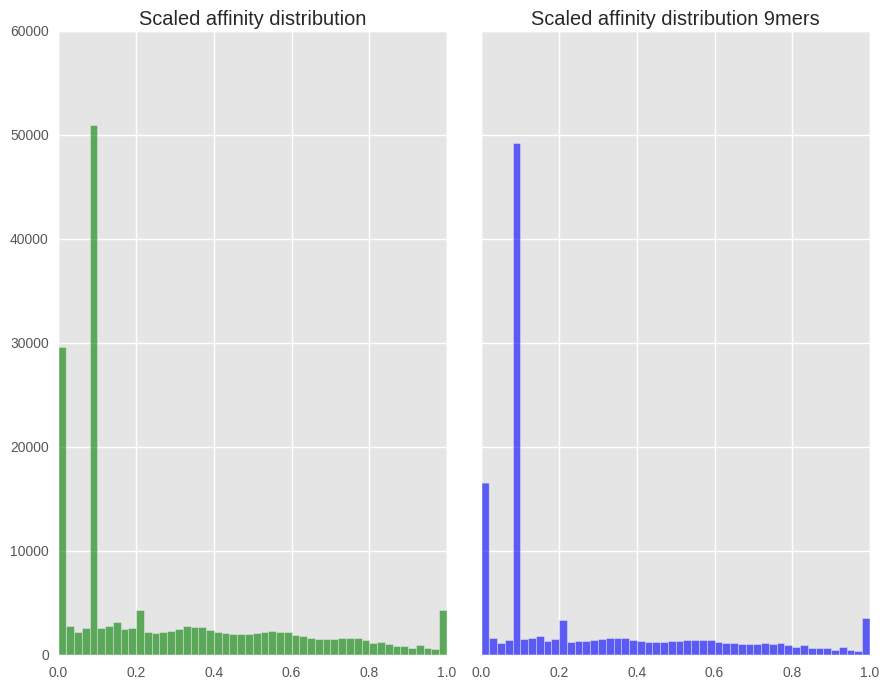

In [5]:
hist, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,7), sharey=True)

ax1.set_title("Scaled affinity distribution")
hh =ax1.hist(Bdata.meas, 50, color = 'green', alpha = 0.6)

ax2.set_title("Scaled affinity distribution 9mers")
hh =ax2.hist(data9mers.meas, 50, color = 'blue', alpha = 0.6)
hist.tight_layout()
hist.subplots_adjust()
plt.savefig("affinity_distr.png")

#### Selecting HLA alleles

In [6]:
hla_abce = select_hla(data9mers)

In [7]:
def get_labels(labels_col):
    le = LabelEncoder()
    return le.fit_transform(labels_col)

## Sequence2Vector
* Word2Vec
* Doc2Vec
* Database of human proteins from uniprot.org
* Peptides from mhc binders
* ProtVec

In [47]:
if os.path.exists("protein_model.pkl"):
    # If model was already trained then just load it.
    w2v_proteins = gensim.models.Word2Vec.load("protein_model.pkl")
else:
    # Else let's train and save it for later reuse
    w2v_proteins = train_seq2vec("uniprot-human.fasta")
    w2v_proteins.save("protein_model.pkl")

INFO : loading Word2Vec object from protein_model.pkl
INFO : setting ignored attribute syn0norm to None
INFO : setting ignored attribute cum_table to None
INFO : loaded protein_model.pkl


In [245]:
protvec_model = biovec.models.load_protvec('/home/rude_mhc/biovec/trained_models/swissprot_reviewed_protvec')

def seq2protvec(seq):
    return sum(protvec_model.to_vecs(seq))

INFO : loading Word2Vec object from /home/rude_mhc/biovec/trained_models/swissprot_reviewed_protvec
INFO : setting ignored attribute syn0norm to None
INFO : setting ignored attribute cum_table to None
INFO : loaded /home/rude_mhc/biovec/trained_models/swissprot_reviewed_protvec


## Dataframes with 9mers peptides

#### 1. Sequence embedding
##### 1.1 Proteins from UniProt

In [11]:
abc_all = pd.read_csv("ABC_all.csv")
abc_all.tail()

len(abc_all)
a = "HLA-A"
b = "HLA-B"
c = "HLA-C"

mhc_labels = 3644*[a]
mhc_labels += 4454*[b]
mhc_labels += 3290*[c]

mhc_labels

index_to_drop = np.random.choice(11388, 416)
mhc_lab = np.delete(np.array(mhc_labels), index_to_drop)
abc_all["length"] = [len(i) for i in abc_all.sequence]

unique_mhc = abc_all.sequence.unique()
a = []
for ind, i in enumerate(abc_all.sequence):
    if "X" in i:
        a.append(ind)
abc_all = abc_all.drop(a).reset_index(drop=True)   
hlaa_labels = le.fit_transform(HLAA.mhc)

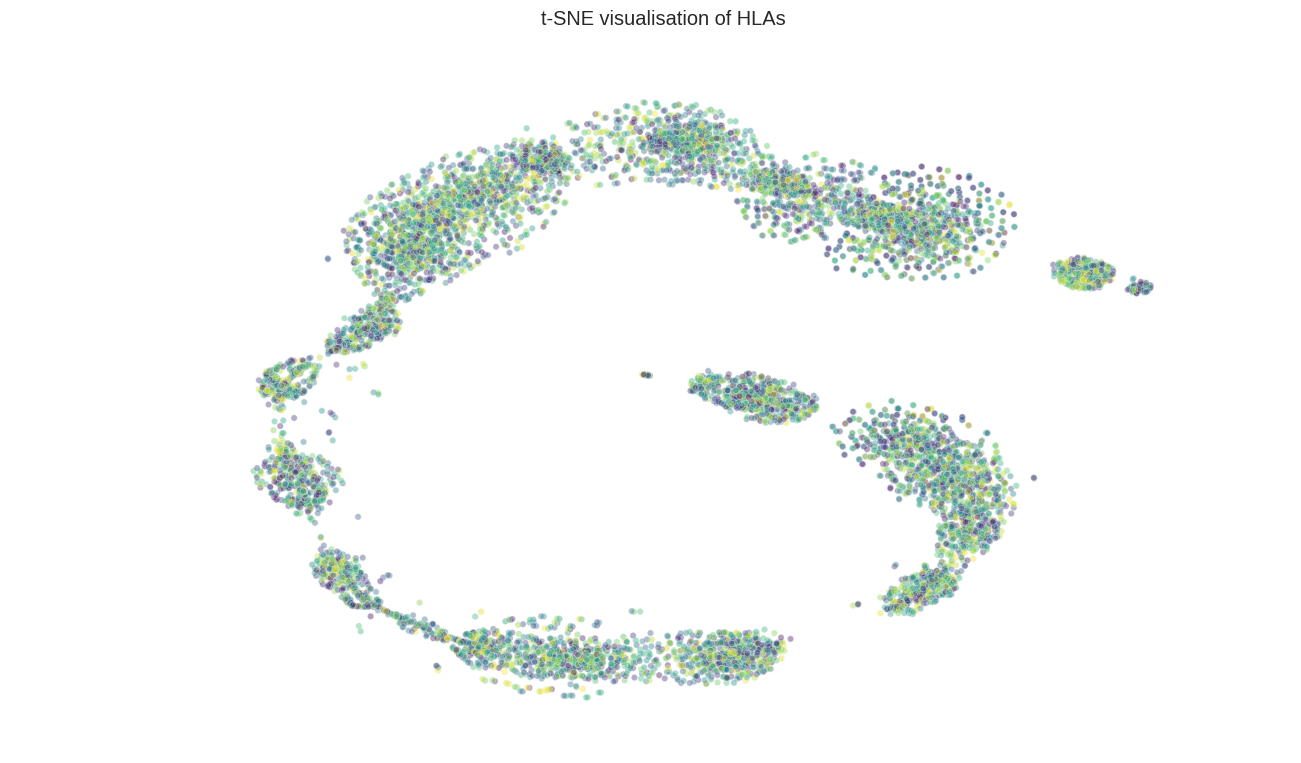

In [28]:
mhc2protvec = pd.DataFrame(abc_all.sequence.apply(seq2protvec)).reset_index(drop=True)
mhc2protvec = pd.DataFrame(list(mhc2protvec.sequence))
mhc2protvec.columns = ["{}_{}".format('mhc2pv', i) for i in mhc2protvec.columns]

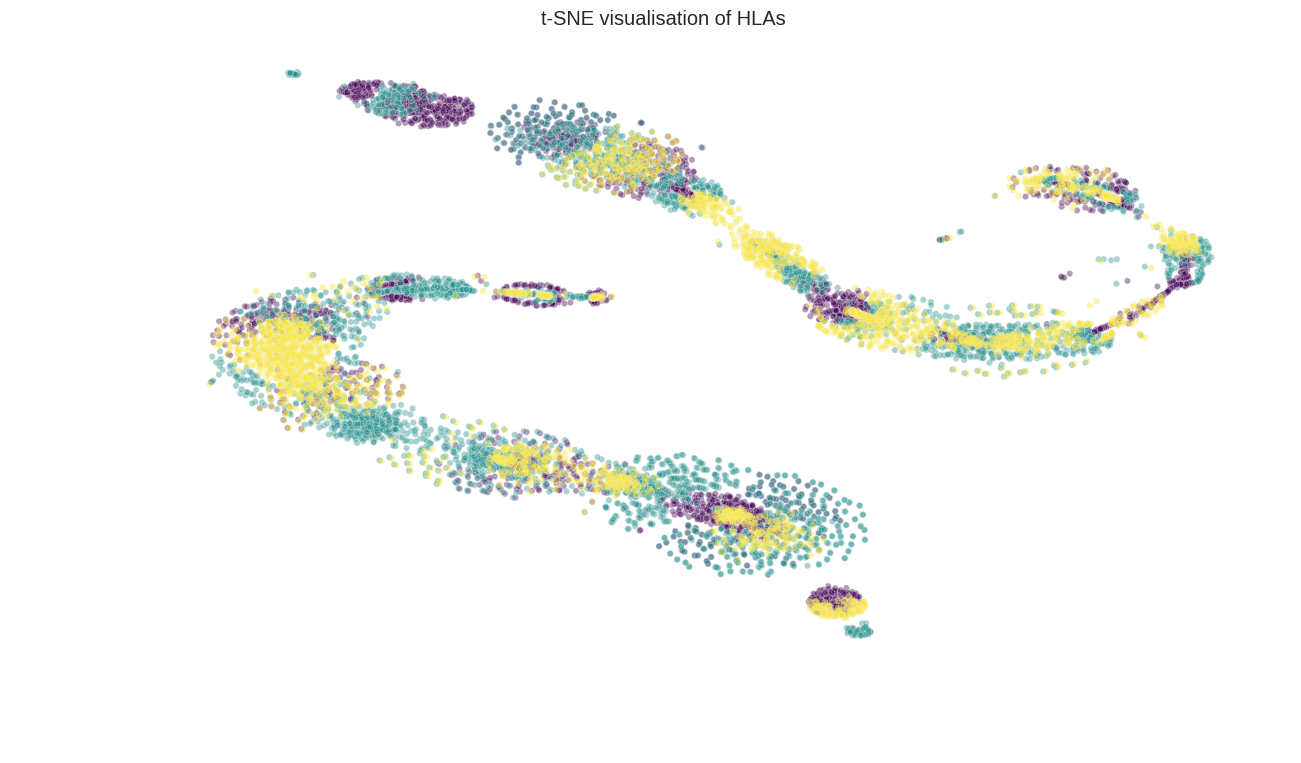

In [61]:
plot_peptide_tsne(mhc2protvec, mhc_labels[:10972], "HLAs")

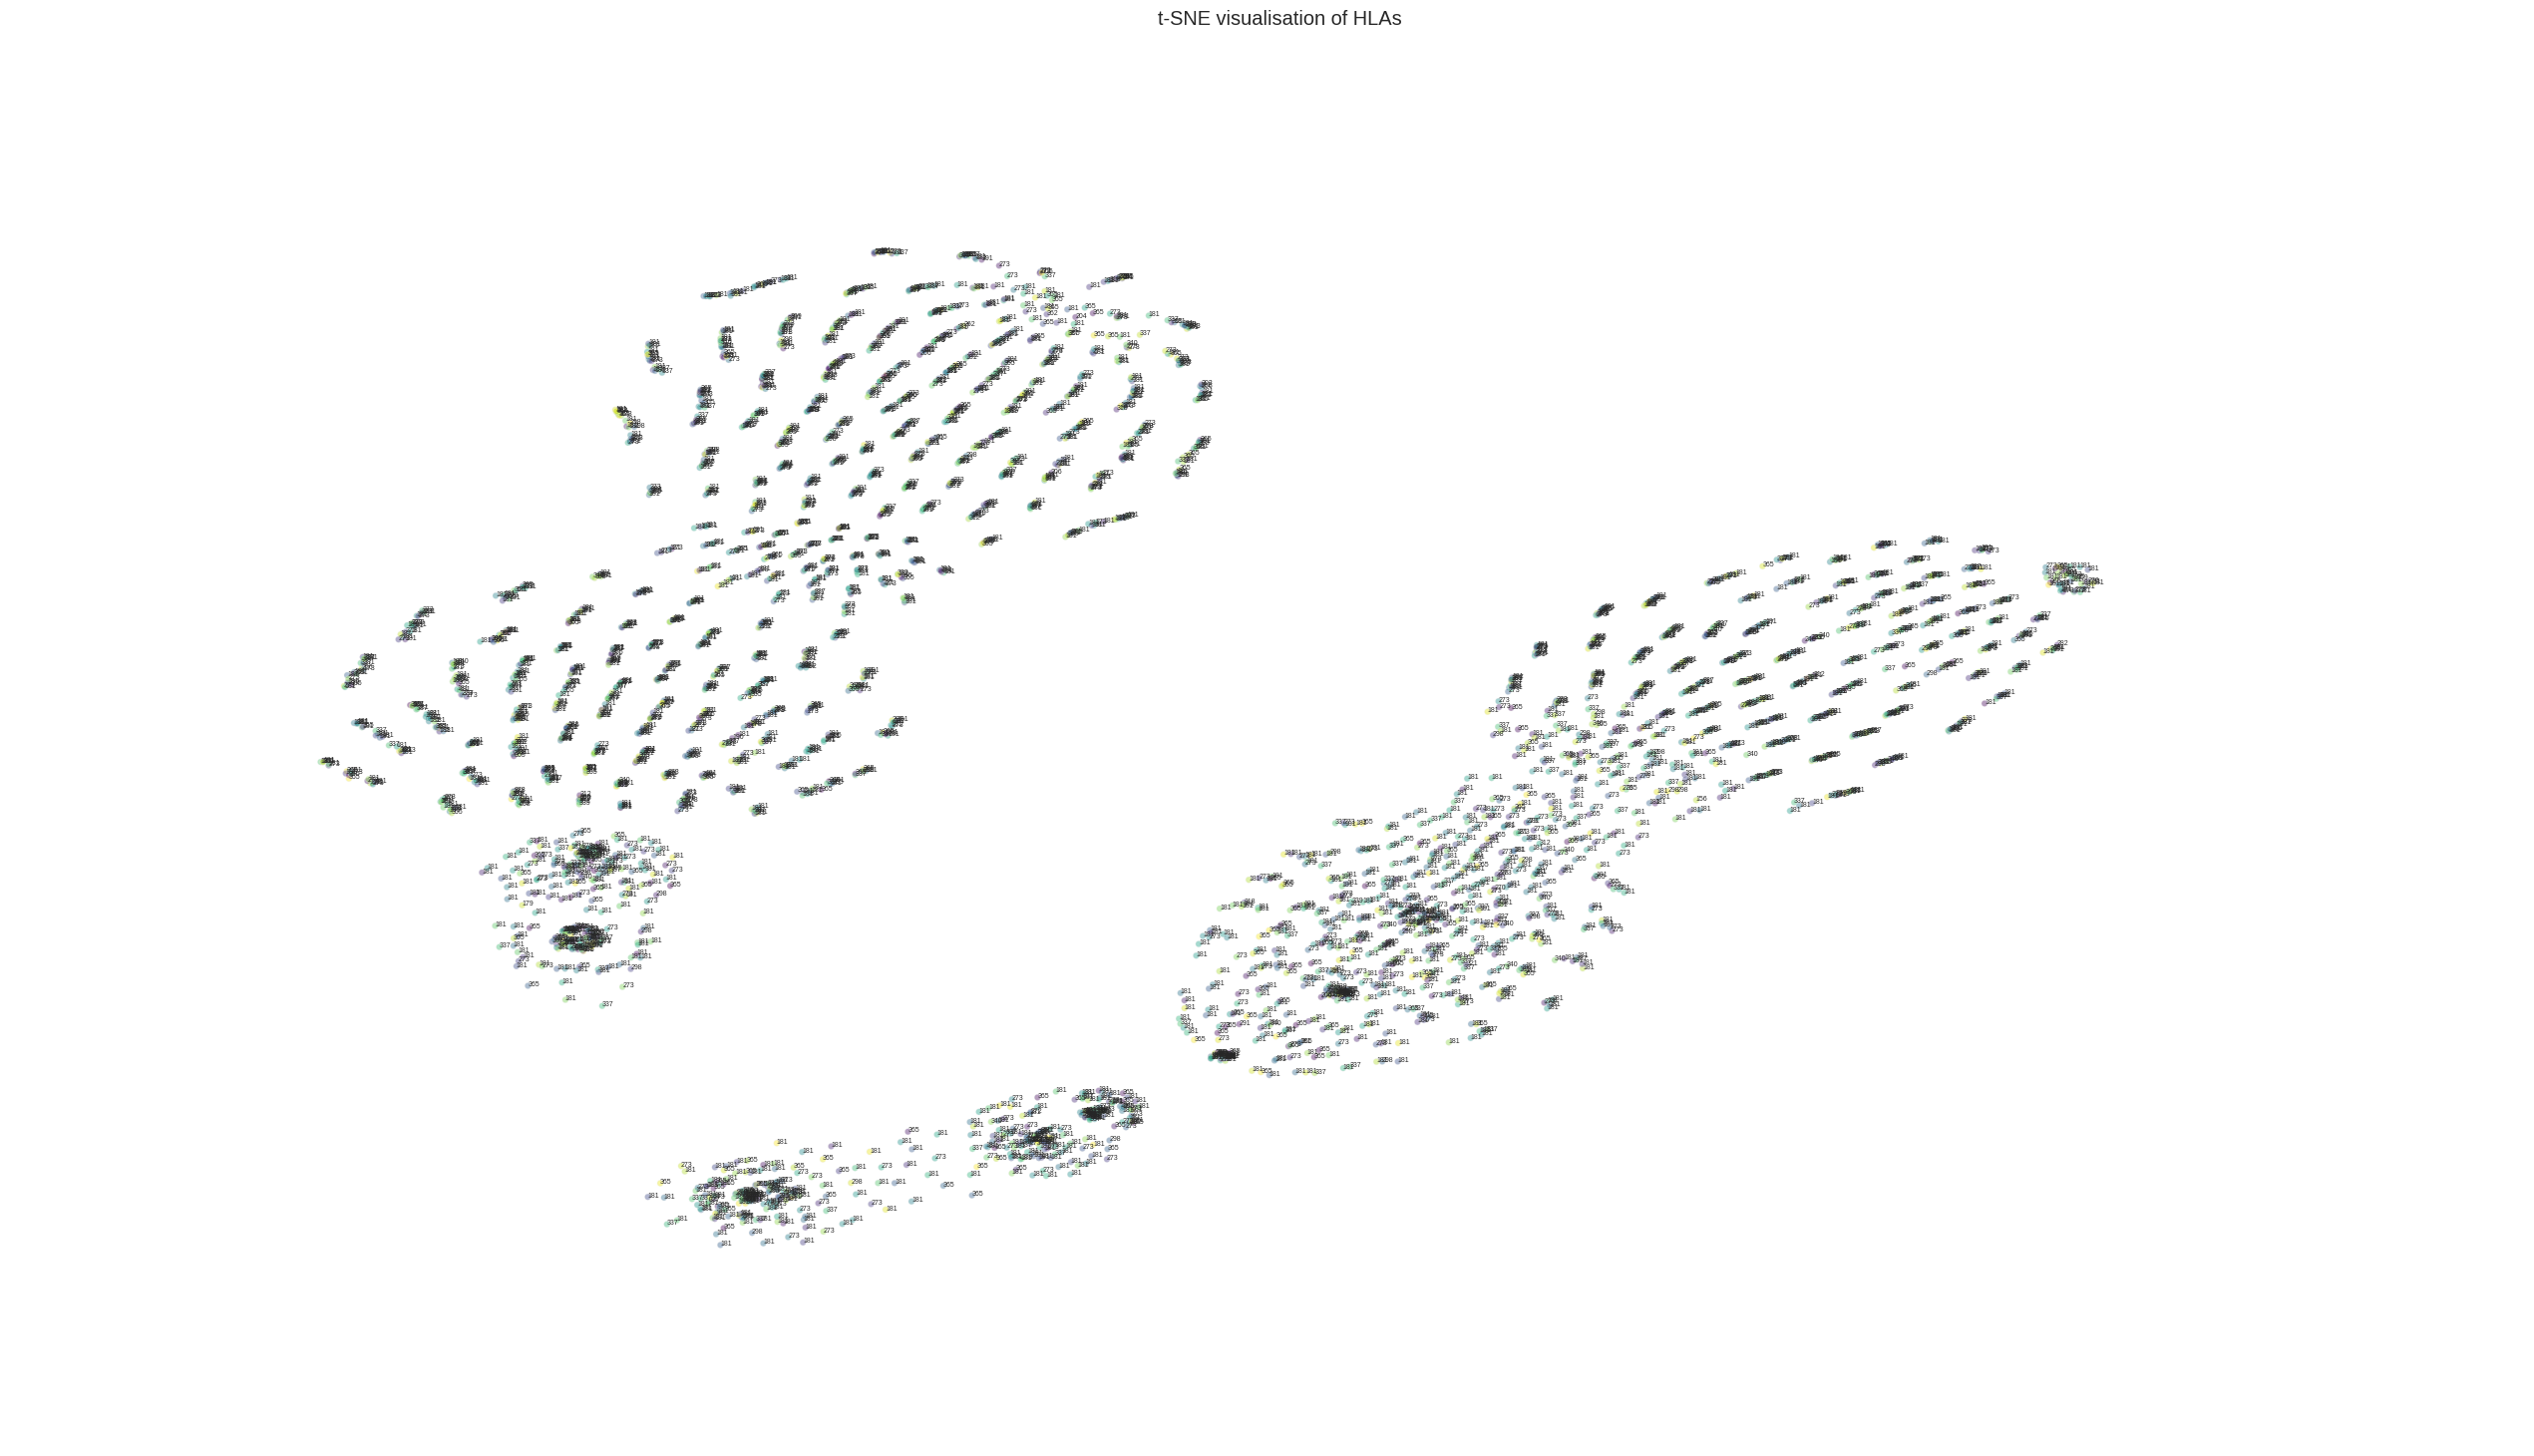

In [76]:
mhc2protvec = pd.DataFrame(HLAA.sequence.apply(seq2protvec)).reset_index(drop=True)
mhc2protvec = pd.DataFrame(list(mhc2protvec.sequence))
mhc2protvec.columns = ["{}_{}".format('mhc2pv', i) for i in mhc2protvec.columns]
plot_peptide_tsne(mhc2protvec, hlaa_labels, "HLAs", HLAA.lenghts)

In [146]:
def check_group(allele):
    if allele.count(":") >= 2:
        return 2
    else:
        return 1

def most_freq(req_seq, seqs):
    pos_strings = []
    new_req_seq = list(req_seq)
    
    for i in range(len(req_seq)):
        cur_pos_string = []
        for cur_seq in seqs:
            cur_pos_string+=cur_seq[i]
        
        pos_strings.append(''.join(cur_pos_string))
    
    for i in range(len(req_seq)):
        new_req_seq[i] = collections.Counter(pos_strings[i]).most_common(1)[0][0]
    
    new_req_seq = ''.join(new_req_seq)
    
    return new_req_seq

def get_seqs_group(allele):
    if check_group(allele) == 2:
        cur_begin = allele[:7]
        cur_seqs = []
        for i in list(dict_seqs.keys()):
            if check_group(i) == 2:
                if i[:7] == cur_begin:
                    cur_seqs.append(dict_seqs[i])
            
    else:
        cur_begin = allele[:4]
        cur_seqs = []
        for i in list(dict_seqs.keys()):
            if check_group(i) == 1:
                if i[:4] == cur_begin:
                    cur_seqs.append(dict_seqs[i])
    return cur_seqs, cur_begin

def get_pseudo_seq(protein):
    positions = [7, 9, 24, 45, 59, 62, 63, 66, 67, 69,
                 70, 73, 74, 76, 77, 80, 81, 84, 85, 97,
                 99, 114, 116, 118, 143, 147, 150, 152, 
                 156, 158, 159, 163, 167, 171]
    
    return "".join([protein[x+23] for x in positions])

In [109]:
dict_seqs = pickle.load(open("allele_algn_prot.p", "rb"))
mhc_seqs = pd.DataFrame.from_dict(dict_seqs, orient="index")
mhc_seqs.columns = ["sequence"]
mhc_seqs["mhc"] = list(mhc_seqs.index)

In [114]:
pseudo_seq_dict = {}
new_dict_seq = {}
new_dict_seq = {}

for i, j in enumerate(mhc_seqs.mhc):
    pseudo_seq_dict[j] = mhc_seqs.mhc_pseudoseq[i]
    
for i in list(pseudo_seq_dict.keys()):
    cur_seqs, cur_allele = get_seqs_group(i)
    new_dict_seq[cur_allele] = most_freq(pseudo_seq_dict[i], cur_seqs)

for i in list(pseudo_seq_dict.keys()):
    cur_seqs, cur_allele = get_seqs_group(i)
    new_dict_seq[cur_allele] = most_freq(pseudo_seq_dict[i], cur_seqs)

In [237]:
mhc_ps = pd.DataFrame.from_dict(new_dict_seq, orient="index")
mhc_ps.columns = ["sequence"]
mhc_ps["mhc"] = ["HLA" + unify_alleles(i) for i in list(mhc_ps.index)]
mhc_ps.reset_index(drop=True, inplace=True)

In [238]:
common = set(mhc_ps.mhc).intersection(set(hla_abce.mhc))
final_ps = mhc_ps[mhc_ps["mhc"].isin(common)].reset_index(drop=True)

to_drop = []
for i in range(len(final_ps.sequence)):
    if "*" in final_ps.sequence[i]:
        to_drop.append(i)

final_ps.drop(final_ps.index[to_drop], inplace=True)
common = set(hla_abce.mhc).intersection(set(final_ps.mhc))
final_ps = final_ps[final_ps["mhc"].isin(common)].reset_index(drop=True)
hla_abce = hla_abce.iloc[np.array(np.where(hla_abce.mhc.apply(lambda x: x in common))).flatten()].reset_index(drop=True)

In [239]:
new_dict = {}

for i, j in zip(list(final_ps.mhc), list(final_ps.sequence)):
    new_dict[i] = j

In [240]:
hla_abce["pseudo"] = [new_dict[i] for i in hla_abce.mhc]

In [246]:
ps_seq2protvec = pd.DataFrame(hla_abce.pseudo.apply(seq2protvec)).reset_index(drop=True)
ps_seq2protvec = pd.DataFrame(list(ps_seq2protvec.pseudo))
ps_seq2protvec.columns = ["{}_{}".format('ps2pv', i) for i in ps_seq2protvec.columns]
ps_seq2protvec.tail()

ps2pv_0   ps2pv_1   ps2pv_2   ps2pv_3   ps2pv_4   ps2pv_5   ps2pv_6  \
109494  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109495  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109496  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109497  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109498  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   

         ps2pv_7   ps2pv_8   ps2pv_9    ...     ps2pv_90  ps2pv_91  ps2pv_92  \
109494  2.556632 -4.021291  5.129523    ...     1.686243  6.669518 -0.219668   
109495  2.556632 -4.021291  5.129523    ...     1.686243  6.669518 -0.219668   
109496  2.556632 -4.021291  5.129523    ...     1.686243  6.669518 -0.219668   
109497  2.556632 -4.021291  5.129523    ...     1.686243  6.669518 -0.219668   
109498  2.556632 -4.021291  5.129523    ...     1.686243  6.669518 -0.219668   

        ps2pv_93  ps2pv_94  ps2pv_95  ps2pv_96  ps2pv_97  ps2pv_98  ps2pv_99  
109494  -2.68693  2.330227 -2.534274  3.810828  -1.81814 -4.112855  6.943153  
109495  -2.68693  2.330227 -2.534274  3.810828  -1.81814 -4.112855  6.943153  
109496  -2.68693  2.330227 -2.534274  3.810828  -1.81814 -4.112855  6.943153  
109497  -2.68693  2.330227 -2.534274  3.810828  -1.81814 -4.112855  6.943153  
109498  -2.68693  2.330227 -2.534274  3.810828  -1.81814 -4.112855  6.943153  

[5 rows x 100 columns]

In [249]:
pep_seq2protvec = pd.DataFrame(hla_abce.sequence.apply(seq2protvec)).reset_index(drop=True)
pep_seq2protvec = pd.DataFrame(list(pep_seq2protvec.sequence))
pep_seq2protvec.columns = ["{}_{}".format('ps2pv', i) for i in pep_seq2protvec.columns]
pep_seq2protvec.tail()

ps2pv_0   ps2pv_1   ps2pv_2   ps2pv_3   ps2pv_4   ps2pv_5   ps2pv_6  \
109494  1.637647 -0.250226  0.171151 -0.522258  1.779720  0.407185  1.404769   
109495  1.378466 -0.178588 -0.315028 -0.312050  1.281434  0.882590  1.164750   
109496  1.146787  0.386411 -0.279392 -0.786721  1.836734 -0.114379  0.912630   
109497  1.704361 -0.267858 -0.975161 -0.727165  1.612176 -0.228845  0.779878   
109498  1.243303 -0.487328 -0.578846 -0.854025  1.233472  0.365593  1.376002   

         ps2pv_7   ps2pv_8   ps2pv_9    ...     ps2pv_90  ps2pv_91  ps2pv_92  \
109494  0.541127 -0.702574  1.823086    ...     0.886645  1.628731  0.712313   
109495  0.667462 -0.952626  1.457322    ...     0.705418  1.260963 -0.223286   
109496  0.441582 -0.684851  1.134377    ...     0.337105  1.909596  0.531314   
109497  0.300179 -0.892996  1.647269    ...     1.022032  1.738719 -0.134328   
109498  0.696676 -0.922215  1.742721    ...     0.846950  1.995625 -0.765107   

        ps2pv_93  ps2pv_94  ps2pv_95  ps2pv_96  ps2pv_97  ps2pv_98  ps2pv_99  
109494 -0.531729  0.908444 -1.175363  0.807263 -0.333965 -0.279877  1.307157  
109495 -0.385531  0.020873 -0.567716  0.574119 -0.855094 -0.758417  1.310873  
109496 -0.015615  0.742208 -0.531490  1.218038 -0.609451 -1.124868  0.857053  
109497 -0.104426  0.955734  0.054431  1.626137 -0.426887 -0.611902  0.945107  
109498 -1.113769  0.333582 -0.494410  0.785710  0.157054 -1.087088  1.233876  

[5 rows x 100 columns]

In [51]:
seq2vec_hlas = pd.DataFrame(hla_abce.sequence.apply(partial(seq2vec, w2v_proteins))).reset_index(drop=True)
seq2vec_hlas = pd.DataFrame(list(seq2vec_hlas.sequence))
seq2vec_hlas.columns = ["{}_{}".format('s2v', i) for i in seq2vec_hlas.columns]
seq2vec_hlas.tail()

s2v_0     s2v_1     s2v_2     s2v_3     s2v_4     s2v_5     s2v_6  \
116950 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116951 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116952 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116953 -0.994039 -1.727786 -1.652630  0.016964  0.106538 -0.573591  1.658975   
116954 -0.994039 -1.727786 -1.652630  0.016964  0.106538 -0.573591  1.658975   

           s2v_7     s2v_8     s2v_9   ...      s2v_170  s2v_171   s2v_172  \
116950  0.216265 -0.187837 -0.514041   ...     0.827864  0.79696 -0.204607   
116951  0.216265 -0.187837 -0.514041   ...     0.827864  0.79696 -0.204607   
116952  0.216265 -0.187837 -0.514041   ...     0.827864  0.79696 -0.204607   
116953 -0.370649  2.343495  1.851265   ...     0.827864  0.79696 -0.204607   
116954 -0.370649  2.343495  1.851265   ...     0.827864  0.79696 -0.204607   

         s2v_173   s2v_174   s2v_175   s2v_176   s2v_177   s2v_178  s2v_179  
116950 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  
116951 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  
116952 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  
116953 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  
116954 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  

[5 rows x 180 columns]

In [17]:
mhc2protvec = pd.DataFrame(hla_abce.mhc_protein.apply(seq2protvec)).reset_index(drop=True)
mhc2protvec = pd.DataFrame(list(mhc2protvec.mhc_protein))
mhc2protvec.columns = ["{}_{}".format('mhc2pv', i) for i in mhc2protvec.columns]
mhc2protvec.tail()

mhc2pv_0   mhc2pv_1   mhc2pv_2   mhc2pv_3   mhc2pv_4   mhc2pv_5  \
116811  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   
116812  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   
116813  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   
116814  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   
116815  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   

         mhc2pv_6   mhc2pv_7  mhc2pv_8   mhc2pv_9    ...      mhc2pv_90  \
116811  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   
116812  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   
116813  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   
116814  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   
116815  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   

        mhc2pv_91  mhc2pv_92  mhc2pv_93  mhc2pv_94  mhc2pv_95  mhc2pv_96  \
116811  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   
116812  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   
116813  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   
116814  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   
116815  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   

        mhc2pv_97  mhc2pv_98  mhc2pv_99  
116811 -14.781194 -30.791248  64.284561  
116812 -14.781194 -30.791248  64.284561  
116813 -14.781194 -30.791248  64.284561  
116814 -14.781194 -30.791248  64.284561  
116815 -14.781194 -30.791248  64.284561  

[5 rows x 100 columns]

In [250]:
final_df = pd.concat([ps_seq2protvec, pep_seq2protvec], axis = 1)
final_df.tail()

ps2pv_0   ps2pv_1   ps2pv_2   ps2pv_3   ps2pv_4   ps2pv_5   ps2pv_6  \
109494  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109495  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109496  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109497  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109498  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   

         ps2pv_7   ps2pv_8   ps2pv_9    ...     ps2pv_90  ps2pv_91  ps2pv_92  \
109494  2.556632 -4.021291  5.129523    ...     0.886645  1.628731  0.712313   
109495  2.556632 -4.021291  5.129523    ...     0.705418  1.260963 -0.223286   
109496  2.556632 -4.021291  5.129523    ...     0.337105  1.909596  0.531314   
109497  2.556632 -4.021291  5.129523    ...     1.022032  1.738719 -0.134328   
109498  2.556632 -4.021291  5.129523    ...     0.846950  1.995625 -0.765107   

        ps2pv_93  ps2pv_94  ps2pv_95  ps2pv_96  ps2pv_97  ps2pv_98  ps2pv_99  
109494 -0.531729  0.908444 -1.175363  0.807263 -0.333965 -0.279877  1.307157  
109495 -0.385531  0.020873 -0.567716  0.574119 -0.855094 -0.758417  1.310873  
109496 -0.015615  0.742208 -0.531490  1.218038 -0.609451 -1.124868  0.857053  
109497 -0.104426  0.955734  0.054431  1.626137 -0.426887 -0.611902  0.945107  
109498 -1.113769  0.333582 -0.494410  0.785710  0.157054 -1.087088  1.233876  

[5 rows x 200 columns]

In [251]:
final_df.to_csv("mhc_pept_pv_HLAs.csv", index=False)

In [252]:
final_df = pd.read_csv("mhc_pept_pv_HLAs.csv")
final_df.tail()

ps2pv_0   ps2pv_1   ps2pv_2   ps2pv_3   ps2pv_4   ps2pv_5   ps2pv_6  \
109494  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109495  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109496  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109497  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   
109498  6.83302 -0.993031 -2.286814 -4.522367  5.317335  2.612496  3.687591   

         ps2pv_7   ps2pv_8   ps2pv_9     ...      ps2pv_90.1  ps2pv_91.1  \
109494  2.556632 -4.021291  5.129523     ...        0.886645    1.628731   
109495  2.556632 -4.021291  5.129523     ...        0.705418    1.260963   
109496  2.556632 -4.021291  5.129523     ...        0.337105    1.909596   
109497  2.556632 -4.021291  5.129523     ...        1.022032    1.738719   
109498  2.556632 -4.021291  5.129523     ...        0.846950    1.995625   

        ps2pv_92.1  ps2pv_93.1  ps2pv_94.1  ps2pv_95.1  ps2pv_96.1  \
109494    0.712313   -0.531729    0.908444   -1.175363    0.807263   
109495   -0.223286   -0.385531    0.020873   -0.567716    0.574119   
109496    0.531314   -0.015615    0.742208   -0.531490    1.218038   
109497   -0.134328   -0.104426    0.955734    0.054431    1.626137   
109498   -0.765107   -1.113769    0.333582   -0.494410    0.785710   

        ps2pv_97.1  ps2pv_98.1  ps2pv_99.1  
109494   -0.333965   -0.279877    1.307157  
109495   -0.855094   -0.758417    1.310873  
109496   -0.609451   -1.124868    0.857053  
109497   -0.426887   -0.611902    0.945107  
109498    0.157054   -1.087088    1.233876  

[5 rows x 200 columns]

In [253]:
mhc_labels = get_labels(hla_abce.mhc)

In [6]:
hla_abce = pd.read_csv("HLAs_common.csv")
hla_abce.tail()

index species       mhc  peptide_length   cv   sequence inequality  \
116811  161617   human  HLAE0103               9  TBD  VMMSEIAGL          =   
116812  161618   human  HLAE0103               9  TBD  VMTTVLATL          =   
116813  161619   human  HLAE0103               9  TBD  VSNLRTGKL          >   
116814  161620   human  HLAE0103               9  TBD  WLPPLLTNL          =   
116815  161621   human  HLAE0103               9  TBD  WMCDRAVDL          >   

            meas                                        mhc_protein  
116811  0.124501  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...  
116812  0.307237  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...  
116813  0.000000  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...  
116814  0.022964  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...  
116815  0.000000  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...

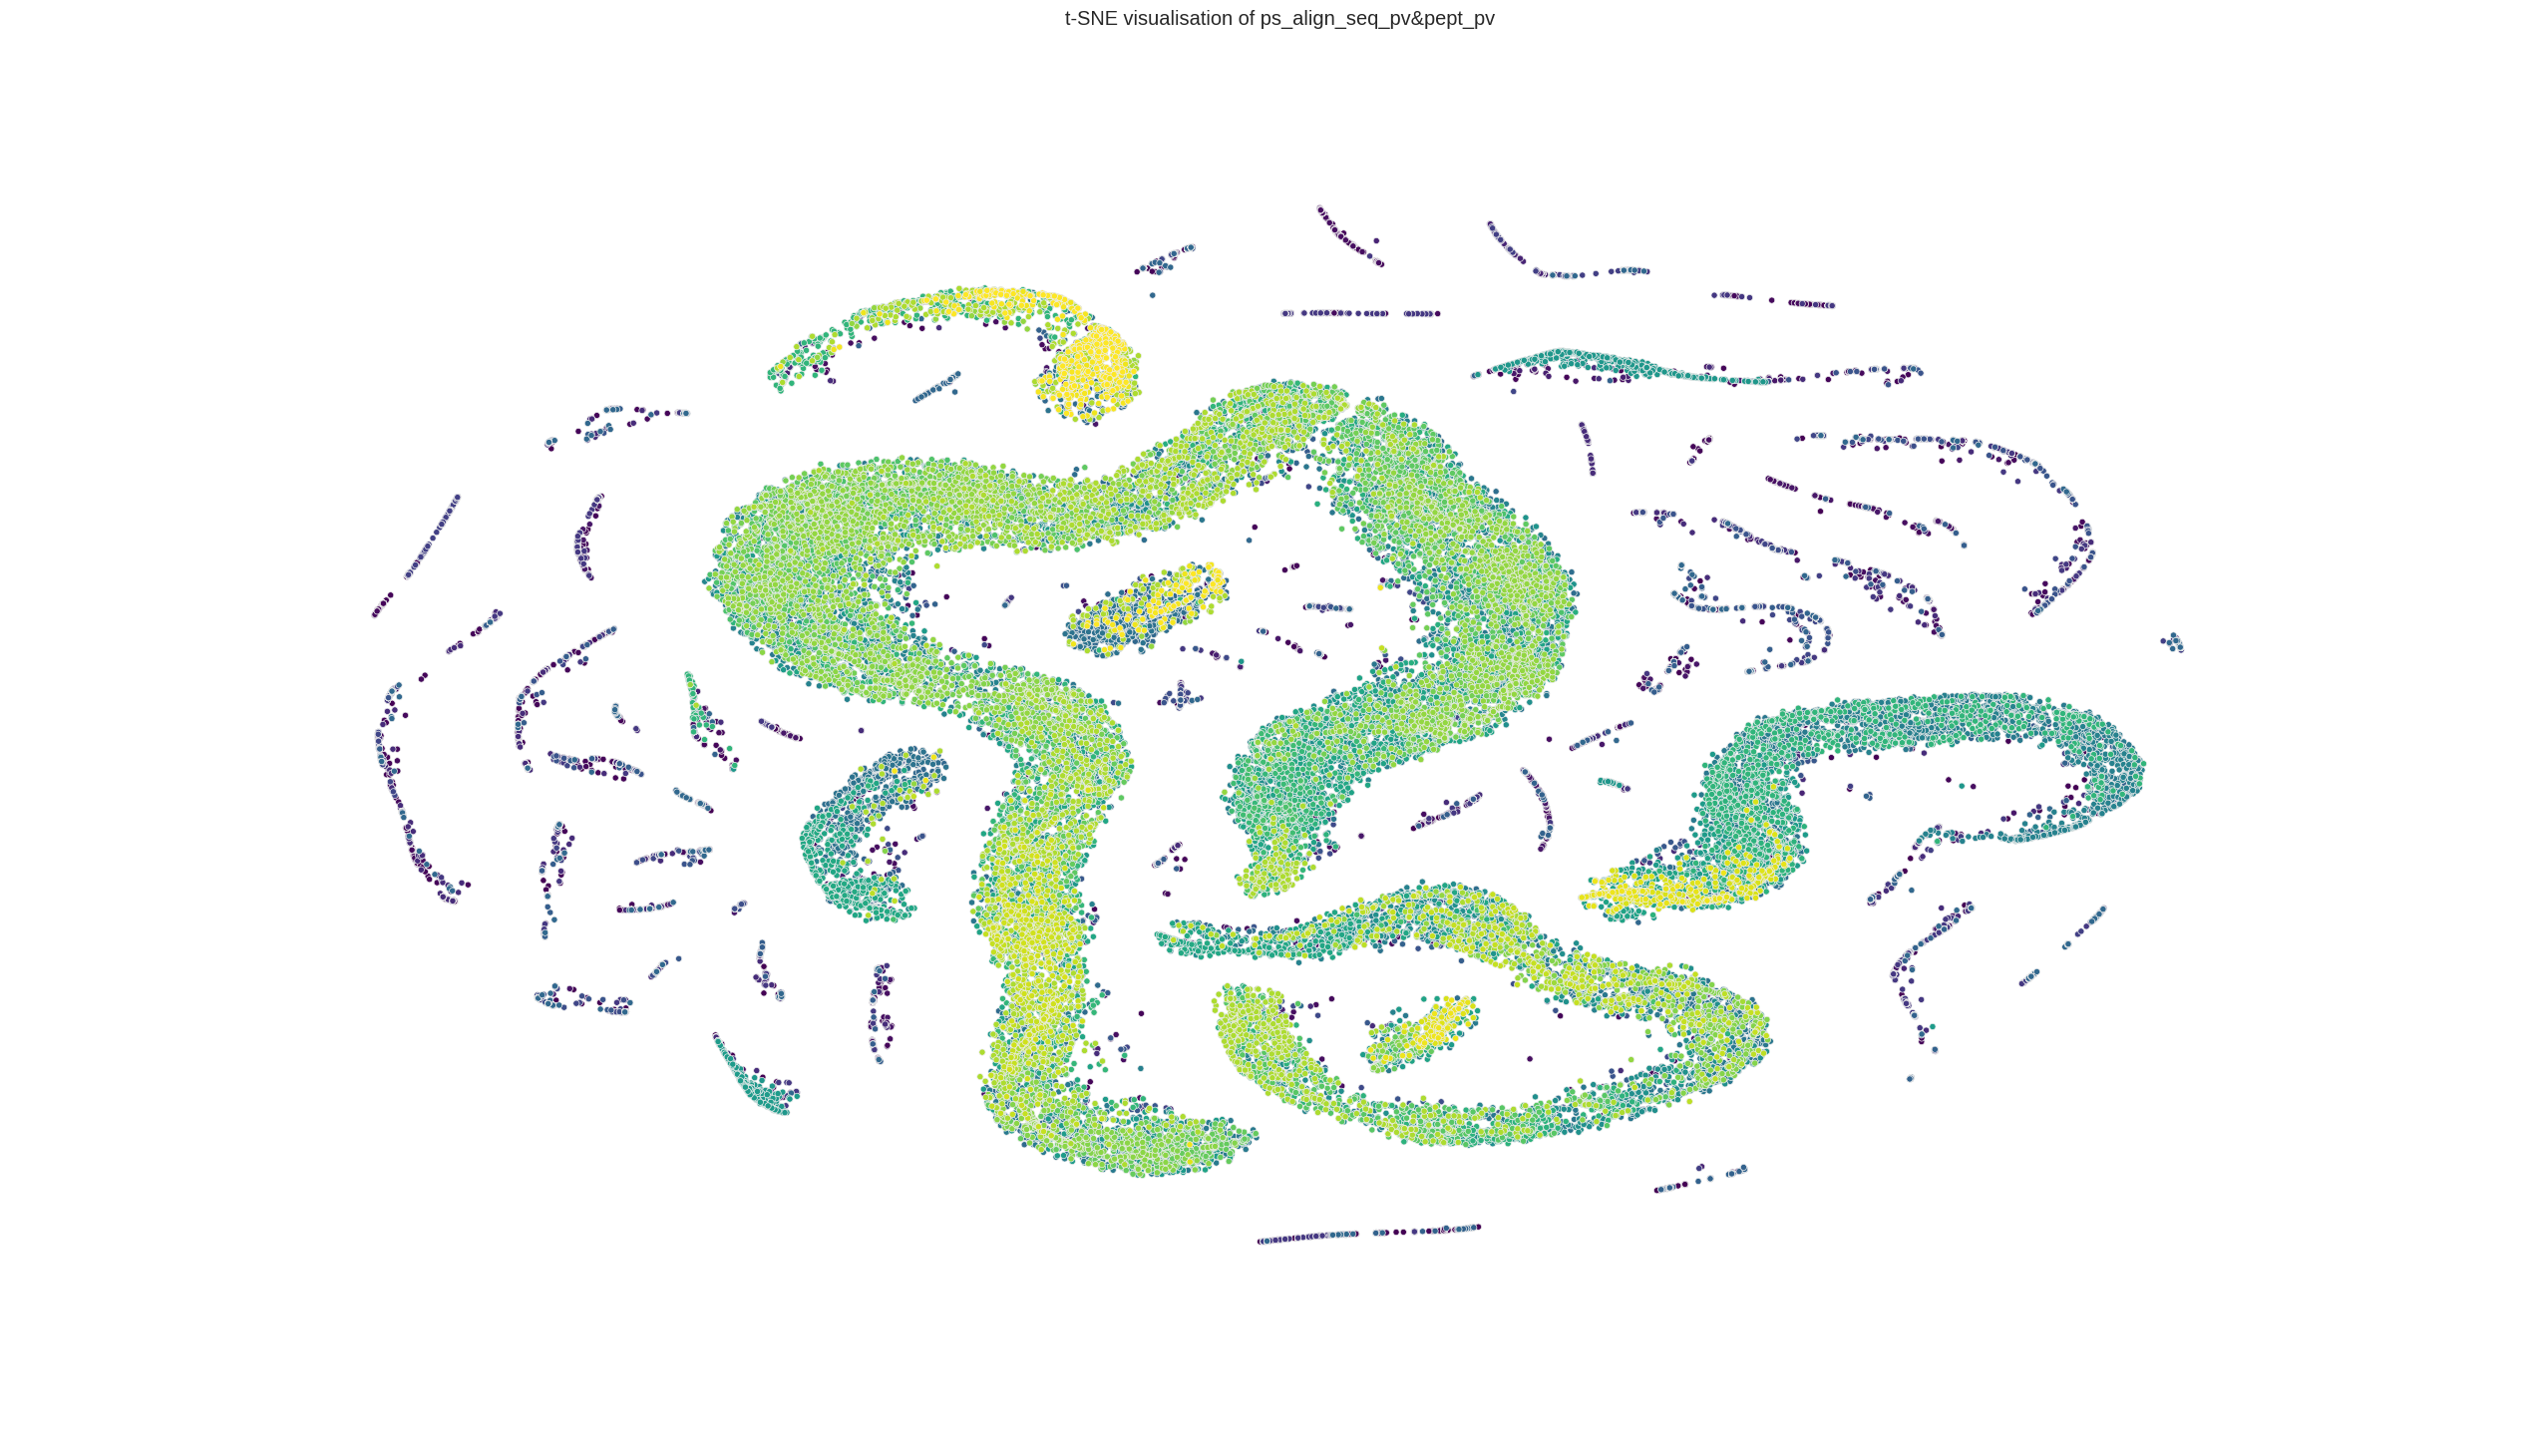

In [256]:
plot_peptide_tsne(final_df, mhc_labels, "ps_align_seq_pv&pept_pv")

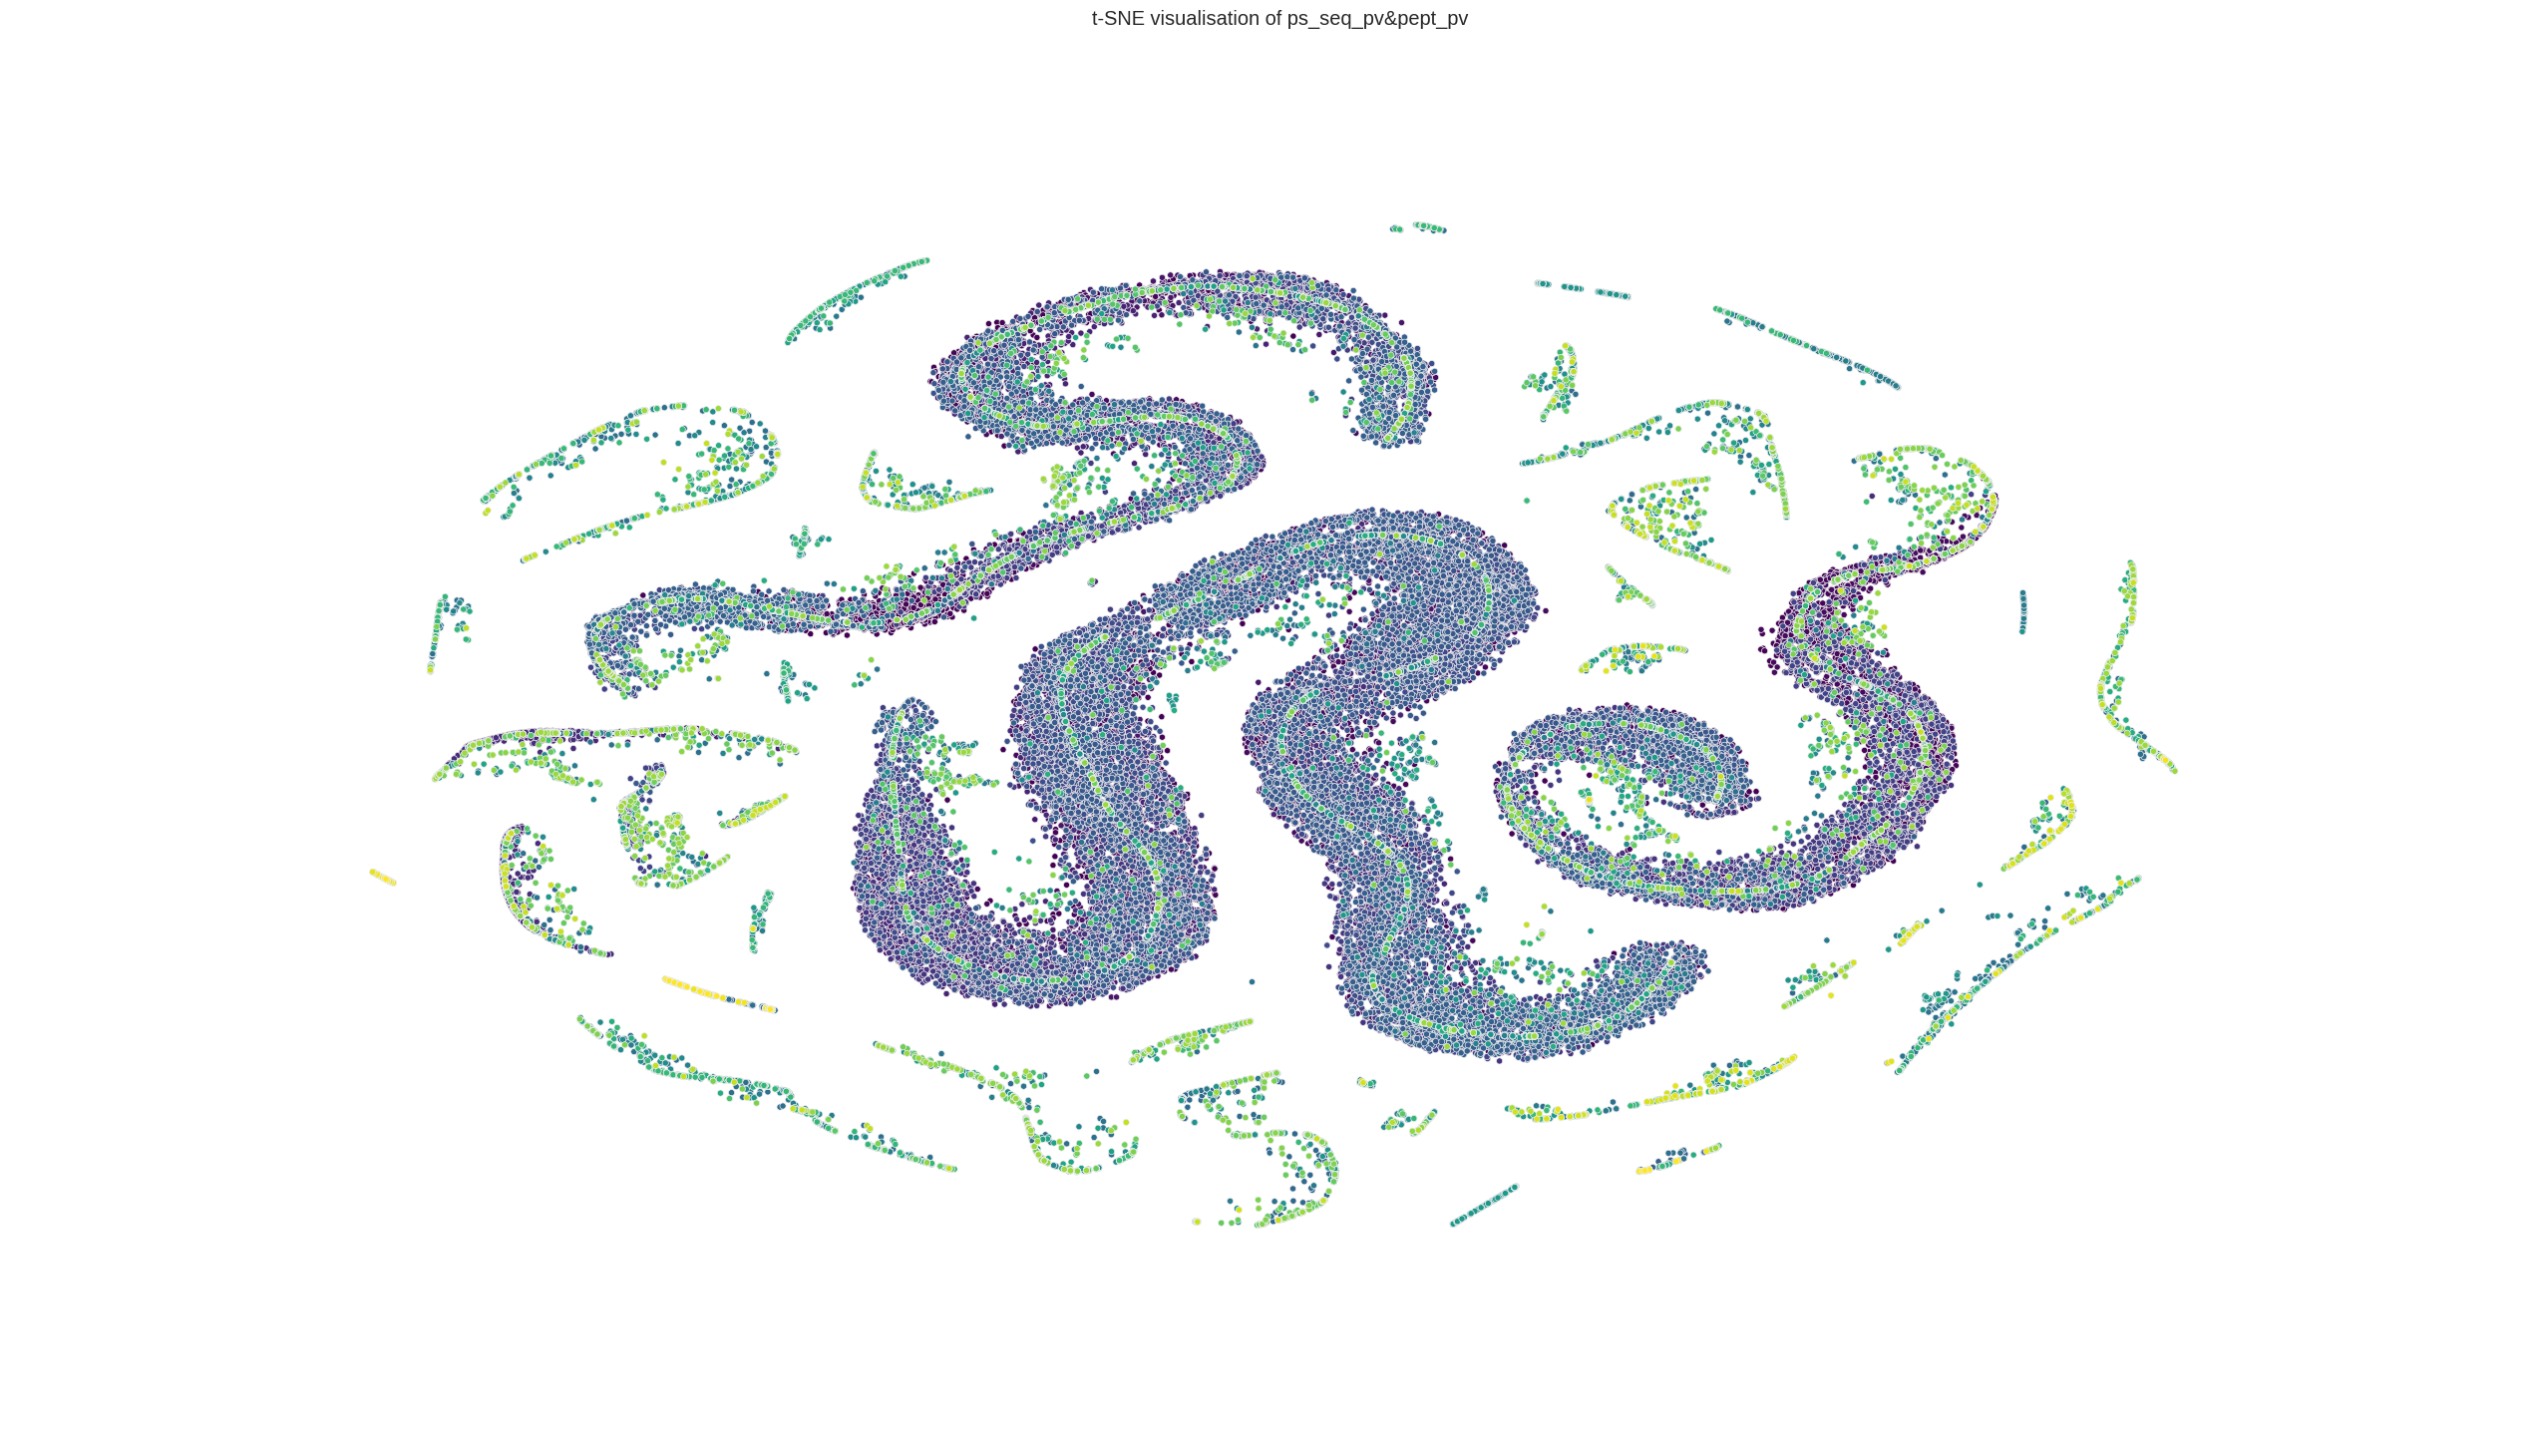

In [36]:
plot_peptide_tsne(final_df, mhc_labels, "ps_seq_pv&pept_pv")

### 7. t-SNE

In [254]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=13, verbose=100, perplexity=200)

In [255]:
def plot_peptide_tsne(data, labels, description):
    
    """
    arguments:
    
    performance - 
    data - DataFrame with data for dimension reduction
    labels - np.array of colors for each point
    description - name for plot and npy array 
    
    --------
    function plot_peptide_tsne reduce dimension to 2 of high-dimensional representation in data and plots tsne 
    """
    if len(data)/tsne.perplexity < 2.1:
        return "perplexity should be higher"
    
    tsne_repr = tsne.fit_transform(data.as_matrix())
    np.save('{}_tsne.npy'.format(description), tsne_repr)
    
    plt.figure(figsize=(32, 18))
    plt.title("t-SNE visualisation of {}".format(description))
    plt.scatter(tsne_repr[:,0], tsne_repr[:,1], c = labels, cmap='viridis', alpha=1)
    ax = plt.axis('off')
    
    """for label, x, y in zip(lenghts, tsne_repr[:, 0], tsne_repr[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', size=5)
        """
    plt.savefig('tsne_{}.png'.format(description), dpi='figure')
    
    

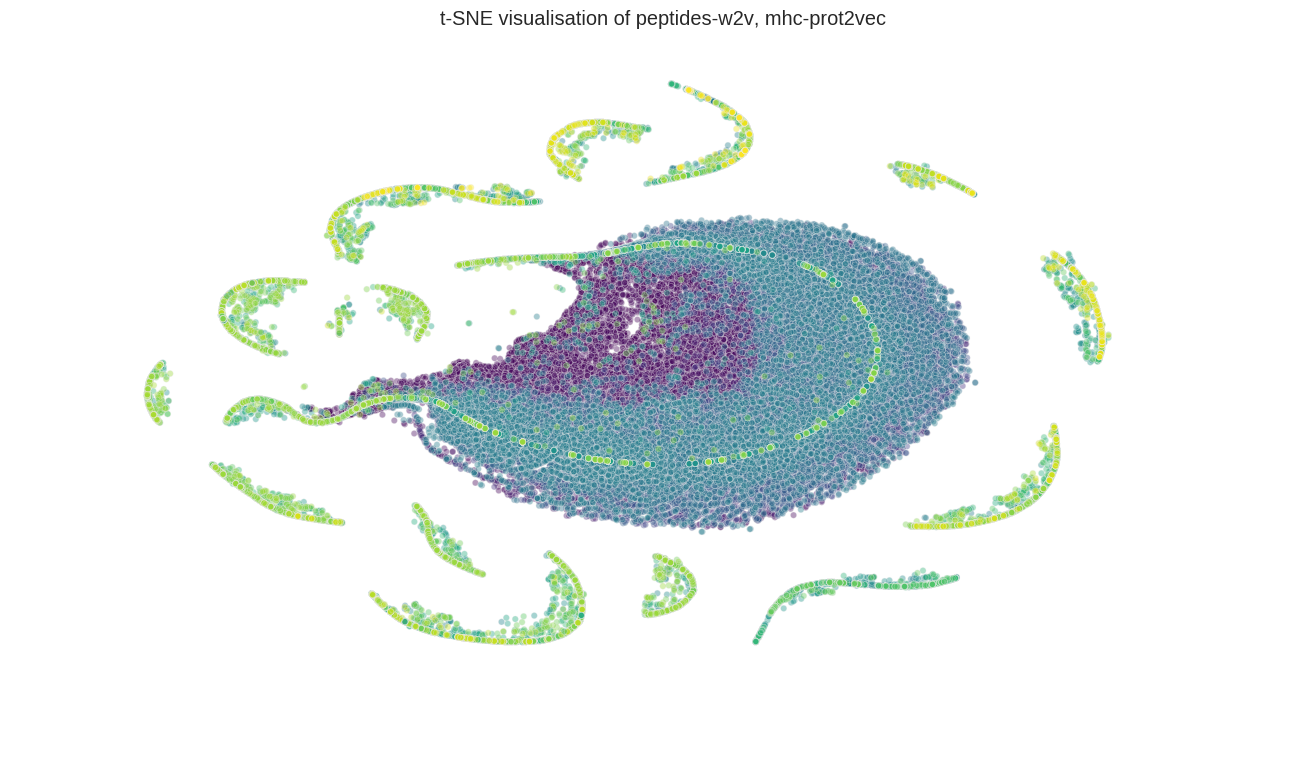

In [59]:
plot_peptide_tsne(final_df, mhc_labels, "peptides-w2v, mhc-prot2vec")

In [46]:
hla = pd.read_csv("HLAs_common.csv")

index species       mhc  peptide_length   cv   sequence inequality  \
116811  161617   human  HLAE0103               9  TBD  VMMSEIAGL          =   
116812  161618   human  HLAE0103               9  TBD  VMTTVLATL          =   
116813  161619   human  HLAE0103               9  TBD  VSNLRTGKL          >   
116814  161620   human  HLAE0103               9  TBD  WLPPLLTNL          =   
116815  161621   human  HLAE0103               9  TBD  WMCDRAVDL          >   

            meas                                        mhc_protein  
116811  0.124501  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...  
116812  0.307237  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...  
116813  0.000000  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...  
116814  0.022964  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...  
116815  0.000000  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...

## Training XGboost

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score
import xgboost as xgb

In [ ]:
{'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 10, 'gamma': 0, 'colsample_bytree': 0.9, 'reg_alpha': 0.01}

In [38]:
def xgb_random_search(data, target):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=442)
    
    param_grid = {
        'colsample_bytree':[0.9, 1.0], 'gamma':[0, 0.01, 0.1], 'reg_alpha':[0.01, 0.03, 0.1], 
        #'reg_lambda':[0.01, 0.1, 1, 5]
    }
    
    gbm = xgb.XGBRegressor(max_depth=8, n_estimators=600, min_child_weight=4, nthread=4, silent=False)
    
    print("RandomSearch proceeding...")
    
    rs = RandomizedSearchCV(gbm, param_grid, n_iter=10, cv=5, n_jobs=3)
    rs.fit(X_train, y_train)
    
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS(validation): ", rs.best_params_, "\n"+101*"="+"\n")
    predictions = rs.best_estimator_.predict(X_test)
    
    print("==================\nRMSE on test : %.4g\n==================" % mean_squared_error(y_test, predictions))
    
    

In [39]:
def xgb_grid_binary(model, params, data, target, cv=2):
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=442)
    
    # train
    
    gbm_params = {
        'min_child_weight': [4, 7], 
    }
    
    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(model, params, n_jobs=-1, cv=cv, verbose=1)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS: ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\AUC : %.4g\n==================" % metrics.roc_auc_score(y_test, predictions))
    

In [40]:
def xgb_grid_regression(data, target):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    
    """dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(dtest)"""
    
    gbm_params = {
        'reg_lambda': [3]
    }
    

    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(xgb.XGBRegressor(max_depth=9, learning_rate=0.1, n_estimators=750, gamma=0, min_child_weight=5,
                                        subsample=0.9, colsample_bytree = 0.9,
                                        nthread=14, silent=False), gbm_params, n_jobs=14, cv=3, verbose=10)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS(validation): ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\nRMSE on test : %.4g\n==================" % metrics.mean_squared_error(y_test, predictions))
    
    

In [258]:
def xgb_regression(data, target):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=442)
    
    """
    T_train_xgb = xgb.DMatrix(X_train, y_train)
    params = {"objective": "reg:linear", 'max_depth':9,
              'learning_rate':0.1, 'n_estimators':750, 'gamma':0, 'min_child_weight':5, 
              'reg_lambda': 0.3, 'subsample': 0.9, 'colsample_bytree':0.9, 'nthread':15}
    
    #cv_res=xgb.cv(params,xgall,100, 3, verbose_eval= 10, metrics='mse', folds=sample_cv)
    gbm = xgb.train(dtrain=T_train_xgb,params=params, num_boost_round=1000)
    pred = gbm.predict(xgb.DMatrix(X_test))
    print("RMSE on test: %.4f" % mean_squared_error(y_test, pred))
    
    """
    
    xgbr = xgb.XGBRegressor(max_depth=9, learning_rate=0.1, n_estimators=750, gamma=0, min_child_weight=5,
                            reg_lambda = 0.3, subsample=0.9, colsample_bytree = 0.9, nthread=15, silent=False)
    
    xgbr.fit(X_train, y_train)
    mse = mean_squared_error(y_test, xgbr.predict(X_test))
    print("RMSE on test: %.4f" % mse)
    return mse


In [31]:
def xgb_regression(data, target, params):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=442)
    
    """
    T_train_xgb = xgb.DMatrix(X_train, y_train)
    params = {"objective": "reg:linear", 'max_depth':9,
              'learning_rate':0.1, 'n_estimators':750, 'gamma':0, 'min_child_weight':5, 
              'reg_lambda': 0.3, 'subsample': 0.9, 'colsample_bytree':0.9, 'nthread':15}
    
    #cv_res=xgb.cv(params,xgall,100, 3, verbose_eval= 10, metrics='mse', folds=sample_cv)
    gbm = xgb.train(dtrain=T_train_xgb,params=params, num_boost_round=1000)
    pred = gbm.predict(xgb.DMatrix(X_test))
    print("RMSE on test: %.4f" % mean_squared_error(y_test, pred))
    
    """
    
    xgbr = xgb.XGBRegressor(**params, nthread=13, silent=False)
    
    xgbr.fit(X_train, y_train)
    preds = xgbr.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    classes = meas2binary(preds)
    
    print("AUC-ROC on test:{}".format(roc_auc_score(meas2binary(y_test), classes)))
    print("RMSE on test:{}".format(mse))
    return mse, preds


### Model evaluation

In [ ]:
affinity = Bdata[Bdata.peptide_length == 9].meas.reset_index(drop=True)
#affinity_classes = affinity_to_classes(affinity)
affinity_binary = affinity_to_binary(affinity)

In [259]:
affinity = hla_abce.meas

In [ ]:
gbm_params = {
        'min_child_weight': [4, 7], 
    }
xgb_grid_binary(xgb.XGBClassifier(), gbm_params, seq2vec9mers_proteins, affinity_binary)

In [ ]:
xgb_regression(pd.concat([seq2vec_hla, pd.DataFrame(hla_tsne, columns=["x_tsne", "y_tsne"])], axis = 1), affinity_hlas)

In [ ]:
#learning_rate and n_estimators tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

In [ ]:
#max_depth and min_child_weight tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

In [ ]:
#gamma tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

In [260]:
#tree structure tuning
xgb_regression(final_df, affinity)

RMSE on test: 0.0515


0.051464024578639668

In [15]:
xgb_random_search(final_df, hla_abce.meas)

RandomSearch proceeding...
Done.
BEST PARAMETERS(validation):  {'reg_alpha': 0.1, 'gamma': 0, 'colsample_bytree': 0.9} 

RMSE on test : 0.04485


In [28]:
def meas2binary(meases):
    return pd.Series(map(lambda x: 1 if x >= log_meas(500) else 0, meases))

In [32]:
best_params = {'n_estimators': 500, 'min_child_weight': 4,
               'max_depth': 10, 'gamma': 0, 
               'colsample_bytree': 0.9, 'reg_alpha': 0.1}

rmse1, preds1 = xgb_regression(final_df, hla_abce.meas, best_params)

AUC-ROC on test:P0.7116972097214712
RMSE on test:0.044717715043922066


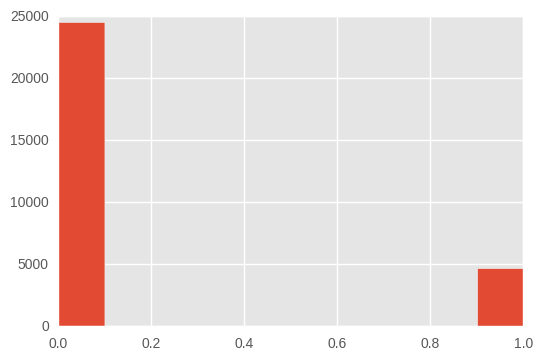

In [34]:
meas2binary(preds1).hist()

In [33]:
xgb_regression(seq2protvec_9mers, hla_abce.meas)

RMSE on test: 0.0586


##  Pipeline

#### objective
* visualise RMSE on every allele

#### steps

* make dataset with sequences and affinities for specific allele
* construct word2vec representation of this sequences
* evaluate xgb model on it
* make 
    
#### important
* gather size of each dataset



In [54]:
from operator import itemgetter
from collections import OrderedDict
import matplotlib.ticker as ticker
import re

In [145]:
def get_rmse_of_models(performance, my_performance, alleles):
    
    """
    arguments:
    
    performance - 
    alleles - list of alleles names
    my_performnace - 
    
    --------
    function get_rmse_of_models extract dataset of specific allele from performance dataset, calculates rmse on 
    each allele and stores it in dicts
    --------
    returns: 3 tuples
    
    netmhc_rmse - tuple of rmse of netmhc on every alelle
    netmhcpan_rmse - tuple of rmse of netmhcpan on every alelle
    pmbec_rmse - tuple of rmse of smm_pmbec on every alelle
    
    """
    
    netmhc_rmse = {}
    netmhcpan_rmse = {}
    pmbec_rmse = {}
    mhc_rmse = {}
    
    for index, cur_al in enumerate(alleles):
        
        cur_alelle = select_by_allele(performance, cur_al)
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", cur_alelle.shape, cur_alelle.meas.shape)
        if(len(cur_alelle) == 0):
            continue
        netmhc_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.netmhc)
        netmhcpan_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.netmhcpan)
        pmbec_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.smmpmbec_cpp)
    
    netmhc_df = pd.DataFrame.from_dict(netmhc_rmse, orient='index')
    netmhcpan_df = pd.DataFrame.from_dict(netmhcpan_rmse, orient='index')
    pmbec_df = pd.DataFrame.from_dict(pmbec_rmse, orient='index')
    xgb_df = pd.DataFrame.from_dict(my_performance, orient='index')

    models_perf = pd.concat([xgb_df, netmhc_df, netmhcpan_df, pmbec_df], axis=1)
    models_perf.columns=["mhystic", "netmhc", "netmhcpan", "pmbec"]
    
    return models_perf


def evaluate_by_allele(w2vmodel, dataset, alleles):
    
    """
    arguments:
    
    alleles - list of alleles names
    --------
    function evaluate_by_allele extract dataset of specific allele from Bdata in which there are sequence and affinity 
    using select_by_allele function, saves it in csv, then constructing word2vec representation of this 
    sequences and evaluates xgb model, which return rmse on this allele.
    --------
    returns: 
    
    mhc_rmse tuple of rmse on every allele in alleles
    """
    
    mhc_rmse = {}
    for index,cur_al in enumerate(alleles):
        
        current_allele = select_by_allele(dataset, cur_al)
        if(len(current_allele) == 1):
            continue
        seq2vec_allele = pd.DataFrame(current_allele.sequence.apply(partial(seq2vec, w2vmodel)), columns=["sequence"])
        seq2vec_allele = pd.DataFrame(list(seq2vec_allele.sequence))
        seq2vec_allele.to_csv("../mhc/w2v_allele#{}.csv".format(cur_al))
        cur_al_affinity = current_allele.meas
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", current_allele.shape, cur_al_affinity.shape)
        allele_rmse = xgb_regression(seq2vec_allele, cur_al_affinity)
        mhc_rmse[cur_al] = allele_rmse
    
    return mhc_rmse

def evaluate_by_allele_protvec(dataset, alleles):
    
    mhc_rmse = {}
    for index,cur_al in enumerate(alleles):
        
        current_allele = select_by_allele(dataset, cur_al)
        
        if(len(current_allele) == 1):
            continue
        
        cur_s2pv = pd.DataFrame(current_allele.sequence.apply(seq2protvec))
        cur_s2pv = pd.DataFrame(list(cur_s2pv.sequence))
        
        cur_al_affinity = current_allele.meas
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", current_allele.shape, cur_al_affinity.shape)
        allele_rmse = xgb_regression(cur_s2pv, cur_al_affinity)
        mhc_rmse[cur_al] = allele_rmse
    
    return mhc_rmse

def plot_results(results, description):
    
    """
    results - DataFrame with columns "mhystic", "netmhc", "netmhcpan", "pmbec"
    
    """
    
    allele_rmse_figure = plt.figure(figsize=(48, 27))
    plt.title("RMSE.{}".format(description))
    plt.xlabel("$RMSE$")
    plt.ylabel("Alleles")

    ind = np.arange(0, 4*len(list(results.index)), 4) 
    width = 0.6
    ys = plt.yticks(ind, list(results.index), rotation=0)
    plt.locator_params(nbins=len(results.mhystic))

    xgb_rects = plt.barh(ind, list(results.mhystic), width, align='center', color='red', alpha=0.3, label = 'MHystic', edgecolor='w')
    plt.barh(ind + width , list(results.netmhc), width, align='center', color='yellow', alpha=0.3, label='netmhc')
    plt.barh(ind + 2*width, list(results.netmhcpan), width, align='center', color='blue', alpha=0.3, label='netmhcpan')
    plt.barh(ind + 3*width, list(results.pmbec), width, align='center', color='black', alpha=0.3, label='pmbec')

    plt.legend(fontsize='xx-large')


    rounded_rmse_xgb = ["{0:.5f}".format(i) for i in list(results.mhystic)]

    for cur_rect, value in zip(xgb_rects.patches, rounded_rmse_xgb):
        plt.text(cur_rect.get_width() +0.001, cur_rect.get_y() - 0.5, value, ha='center', va='bottom', fontsize=15)

    
    allele_rmse_figure.savefig('rmse {}.png'.format(description), dpi=allele_rmse_figure.dpi)

In [112]:
performance_data = pd.read_csv("model_performance_logged.csv").drop("Unnamed: 0", axis=1)
performance_data.tail()

mhc      meas    netmhc  netmhcpan  smmpmbec_cpp
21377  Mamu-A02  0.747391  0.434557   0.605658      0.567139
21378  Mamu-A02  0.022339  0.293037   0.202166      0.371139
21379  Mamu-A02  0.028511  0.283247   0.148324      0.273245
21380  Mamu-A02  0.141940  0.079586   0.195356      0.143642
21381  Mamu-A02  0.535430  0.496485   0.389441      0.569267

In [125]:
unify_alleles = lambda x: re.sub('-', '', x)

performance_data.mhc = performance_data.mhc.apply(unify_alleles)
data9mers.mhc.replace(unify_alleles, inplace=True)

common_alleles = list(set(data9mers.mhc).intersection(performance_data.mhc))

In [132]:
errors = evaluate_by_allele(w2v_proteins, data9mers, common_alleles)


#0 MamuA01:
Shapes:  (909, 7) (909,)
RMSE on test: 0.0448

#1 HLAB3801:
Shapes:  (491, 7) (491,)
RMSE on test: 0.0197

#2 HLAA0101:
Shapes:  (3680, 7) (3680,)
RMSE on test: 0.0175

#3 HLAA3101:
Shapes:  (3860, 7) (3860,)
RMSE on test: 0.0276

#4 HLAA2402:
Shapes:  (2360, 7) (2360,)
RMSE on test: 0.0337

#5 HLAB0801:
Shapes:  (2817, 7) (2817,)
RMSE on test: 0.0347

#6 HLAB5101:
Shapes:  (2031, 7) (2031,)
RMSE on test: 0.0168

#7 HLAA0201:
Shapes:  (8826, 7) (8826,)
RMSE on test: 0.0288

#8 HLAB3901:
Shapes:  (1525, 7) (1525,)
RMSE on test: 0.0200

#9 HLAB2705:
Shapes:  (2587, 7) (2587,)
RMSE on test: 0.0155

#10 HLAA0301:
Shapes:  (5231, 7) (5231,)
RMSE on test: 0.0215

#11 HLAB4601:
Shapes:  (1784, 7) (1784,)
RMSE on test: 0.0097

#12 HLAB5701:
Shapes:  (2404, 7) (2404,)
RMSE on test: 0.0113

#13 HLAB1801:
Shapes:  (2190, 7) (2190,)
RMSE on test: 0.0187

#14 HLAA2501:
Shapes:  (935, 7) (935,)
RMSE on test: 0.0157

#15 HLAB5301:
Shapes:  (937, 7) (937,)
RMSE on test: 0.0387

#16 HLAB44

In [135]:
np.save("xgb_rmse_9mers_protvec.npy", errors) #skl
errors = OrderedDict(sorted(errors.items(), key=lambda t: t[0]))
performance_df = get_rmse_of_models(performance_data, errors, common_alleles, )


#0 MamuA01:
Shapes:  (73, 4) (73,)

#1 HLAB3801:
Shapes:  (351, 4) (351,)

#2 HLAA0101:
Shapes:  (479, 4) (479,)

#3 HLAA3101:
Shapes:  (521, 4) (521,)

#4 HLAA2402:
Shapes:  (346, 4) (346,)

#5 HLAB0801:
Shapes:  (707, 4) (707,)

#6 HLAB5101:
Shapes:  (673, 4) (673,)

#7 HLAA0201:
Shapes:  (1778, 4) (1778,)

#8 HLAB3901:
Shapes:  (641, 4) (641,)

#9 HLAB2705:
Shapes:  (249, 4) (249,)

#10 HLAA0301:
Shapes:  (591, 4) (591,)

#11 HLAB4601:
Shapes:  (378, 4) (378,)

#12 HLAB5701:
Shapes:  (647, 4) (647,)

#13 HLAB1801:
Shapes:  (503, 4) (503,)

#14 HLAA2501:
Shapes:  (416, 4) (416,)

#15 HLAB5301:
Shapes:  (296, 4) (296,)

#16 HLAB4403:
Shapes:  (205, 4) (205,)

#17 HLAA0203:
Shapes:  (460, 4) (460,)

#18 HLAB4501:
Shapes:  (65, 4) (65,)

#19 HLAB1503:
Shapes:  (165, 4) (165,)

#20 HLAB1501:
Shapes:  (633, 4) (633,)

#21 HLAB1517:
Shapes:  (582, 4) (582,)

#22 HLAA0202:
Shapes:  (126, 4) (126,)

#23 HLAA3201:
Shapes:  (256, 4) (256,)

#24 MamuA02:
Shapes:  (125, 4) (125,)

#25 HLAA2601:

/home/rude_mhc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


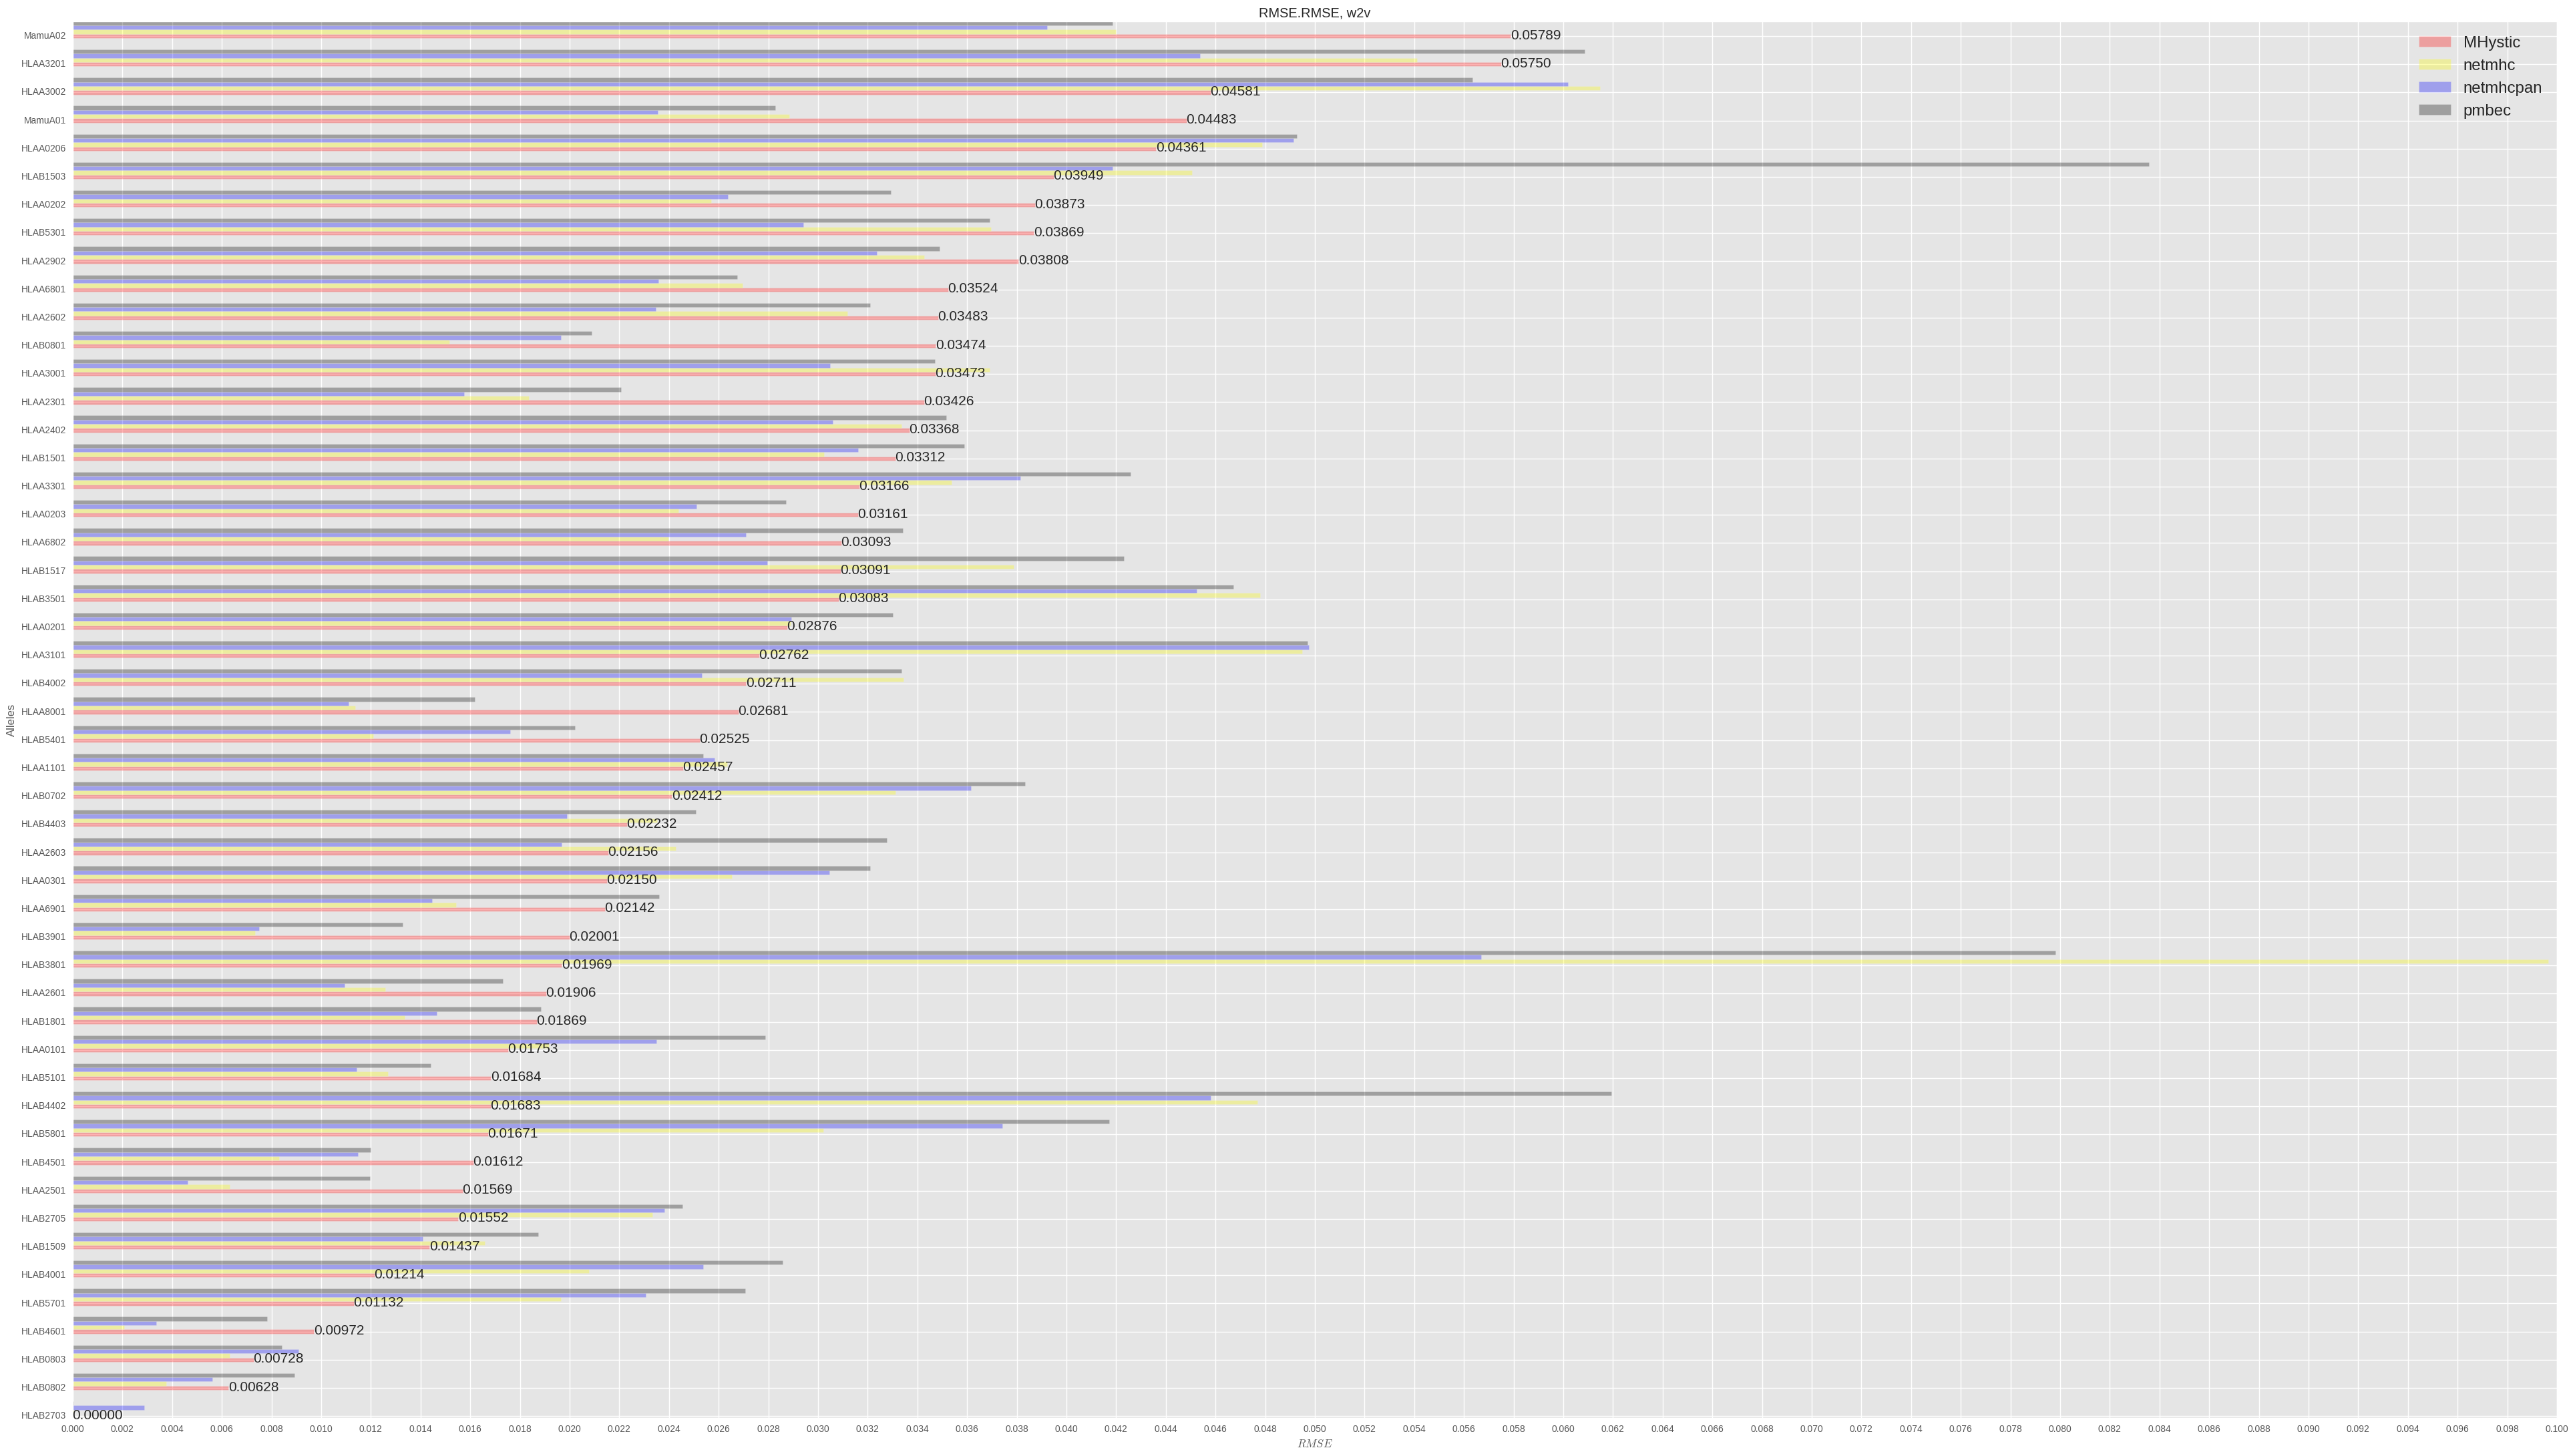

In [146]:
plot_results(performance_df.sort('mhystic', ascending=True), "RMSE, w2v")